In [357]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
import seaborn as sns
import sys
import os
from os import path
import yaml
import copy
import statsmodels.stats.proportion as ssp

In [2]:
os.chdir('..')

In [3]:
from matplotlib.transforms import Affine2D

In [413]:
from mega_analysis.crosstab.mega_analysis.MEGA_ANALYSIS import MEGA_ANALYSIS
from mega_analysis.crosstab.mega_analysis.QUERY_SEMIOLOGY import QUERY_SEMIOLOGY
from mega_analysis.crosstab.NORMALISE_TO_LOCALISING_VALUES import NORMALISE_TO_LOCALISING_VALUES
from mega_analysis.crosstab.file_paths import file_paths
from mega_analysis.crosstab.lobe_top_level_hierarchy_only import top_level_lobes
from mega_analysis.crosstab.hierarchy_dictionaries import temporal_postcodes
from mega_analysis.semiology import recursive_items


In [51]:
from scripts import multinomial_ci_python
# https://github.com/doctorcanada/multinomial_ci_python/blob/master/multinomial_ci.py
# Implementation by Dr Brian Canada
# Originally formulated by Sison, C. &  Glaz, J.

# Define lists & file paths

In [6]:
repo_dir, resources_dir, excel_path, semiology_dict_path = file_paths()

Semio2Brain_Database = r'/Volumes/Encrypted/Semiology-Visualisation-Tool/resources/__Semio2Brain Database v1.1.0.xlsx'

with open(semiology_dict_path) as f:
    SemioDict = yaml.load(f, Loader=yaml.FullLoader)

In [646]:
top_level = top_level_lobes()
n_top_level_lobes = len(top_level)
top_level_of_interest = [
                         'TL',
                         'FL',
                         'PL',
                         'OL',
                         'INSULA',
                         'CING',
                         'Hypothalamus',
                        ]
top_level_all_other = list(set(top_level) - set(top_level_of_interest))
top_level_of_interest_minus_tl = list(set(top_level_of_interest) - set(['TL']))

low_level_temporal_all =  [y for x in temporal_postcodes.values() for y in x]
low_level_temporal_of_interest = ['Anterior (temporal pole)',
                                  'Lateral Temporal',
                                  'Mesial Temporal',
                                  'Posterior Temporal',
                                  'Basal (including Fusiform OTMG)']

low_level_temporal_other =  list(set(low_level_temporal_all) - set(low_level_temporal_of_interest))

roi_clean_labels = ['Anterior Temporal',
 'Lateral Temporal',
 'Mesial Temporal',
 'Posterior Temporal',
 'Basal Temporal',
 'Cingulate Gyrus',
 'Frontal Lobe',
 'Parietal Lobe',
 'Hypothalamus',
 'Insula',
 'Occipital Lobe',
 'Interlobar Junctions+']

region_names = {'top_level': top_level,
                'of_interest': top_level_of_interest,
                'of_interest_minus_tl': top_level_of_interest_minus_tl,
                'top_level_all_other': top_level_all_other,
                'top_level_temporal': ['TL'],
                'low_level_temporal_all': low_level_temporal_all,
                'low_level_temporal_of_interest': low_level_temporal_of_interest,
                'low_level_temporal_other': low_level_temporal_other,
                'roi_clean_labels': roi_clean_labels}

# Query excel sheet

In [7]:
(original_df, 
df_ground_truth, df_study_type,
num_database_articles, num_database_patients, num_database_lat, num_database_loc) = \
                MEGA_ANALYSIS(Semio2Brain_Database)
df = original_df.copy()
print(df.shape)

(2577, 121)


In [8]:
df_ss = df.copy()
df_ss['Spontaneous Semiology (SS)'] = df_ss['Spontaneous Semiology (SS)'].replace('y', True)
df_ss = df_ss[df_ss['Spontaneous Semiology (SS)']==True]
print(df_ss.shape)

(1263, 121)


In [9]:
df_not_ss = df.copy()
df_not_ss['Spontaneous Semiology (SS)'] = df_not_ss['Spontaneous Semiology (SS)'].replace('y', True)
df_not_ss = df_not_ss[df_not_ss['Spontaneous Semiology (SS)']!=True]
print(df_not_ss.shape)

(1314, 121)


In [228]:
raw_dfs = {
    'full': df,
    'ss': df_ss,
    'not_ss': df_not_ss,
}

In [226]:
semiology_list = list(recursive_items(SemioDict))

In [414]:
NORMALISE_TO_LOCALISING_VALUES(one_query_result)

<function mega_analysis.crosstab.NORMALISE_TO_LOCALISING_VALUES.NORMALISE_TO_LOCALISING_VALUES(inspect_result, type='all')>

In [415]:
def query_semiology_wrapper(df, semiology_list, normalise=False):
    semiology_query_results = {}
    for semiology in semiology_list:
        query_inspection, num_query_lat, num_query_loc = QUERY_SEMIOLOGY(df,
                                                                     semiology_term=semiology,
                                                                     ignore_case=True,
                                                                     semiology_dict_path=None,
                                                                     all_columns_wanted = True)
                                                                             # col1=col1, col2=col1)
        if normalise:
            query_inspection = NORMALISE_TO_LOCALISING_VALUES(query_inspection)
            
        one_query_result = {
            'query_inspection': query_inspection,
            'num_query_lat': num_query_lat,
            'num_query_loc': num_query_loc
        }
        semiology_query_results[semiology] = one_query_result
    return semiology_query_results

In [927]:
query_results = {}
for raw_df_key, raw_df in raw_dfs.items():
    query_results[raw_df_key] = query_semiology_wrapper(raw_df, semiology_list, normalise=False)

In [928]:
query_results_normalise = {}
for raw_df_key, raw_df in raw_dfs.items():
    query_results_normalise[raw_df_key] = query_semiology_wrapper(raw_df, semiology_list, normalise=True)

In [733]:
def get_top_semiologies(query_result, threshold):
    n_results = []
    for k, v in query_result.items():
        n_results.append(v['num_query_loc'])
    n_results = np.array(n_results)
    total_results_standard = n_results.sum()
    top_9_semiologies = np.array(semiology_list)[(n_results>threshold)]
    return top_9_semiologies

In [745]:
top_8_semiologies = get_top_semiologies(query_results['full'], 220)
top_9_semiologies = get_top_semiologies(query_results['full'], 190)
top_20_semiologies = get_top_semiologies(query_results['full'], 60)

- group basal inc. OTMG (fusiform) DONE
- discard other temporal categories DONE
- proportion_confint - coun Nobs = total for semiolog
- Order - as in df
- bootstrapping ?QUERY
- divide by all cases in a region - is that meaning all cases across all semiologies?
- plot spontaneous semiology ONLY on top/below normal DONE

# Interogate query - proportions etc

In [18]:
def get_counts_df(query_results, region_names, merge_temporal = False, other_included = True):
    columns_of_interest = []
    counts_matrix = []
    for semiology, value in query_results.items():
        query_inspection = value['query_inspection']
        if merge_temporal == False:
            columns_of_interest = (region_names['low_level_temporal_of_interest'] + region_names['of_interest_minus_tl'])
        else:
            columns_of_interest = copy.deepcopy(region_names['of_interest'])
        if other_included:
            columns_of_interest += region_names['top_level_all_other']
        semiology_counts = query_inspection[columns_of_interest].sum().values
        counts_matrix.append(semiology_counts)
    counts_df = pd.DataFrame(counts_matrix, index=query_results.keys(), columns=columns_of_interest)
    return counts_df

In [366]:
def merge_all_other_semiologies(counts_df, semiologies_of_interest):
    of_interest_mask = counts_df.index.isin(semiologies_of_interest)
    to_merge_df = counts_df.loc[~of_interest_mask]
    to_merge_df_sum = to_merge_df.sum(0)
    dropped_df = counts_df.drop(to_merge_df.index, 'index')
    dropped_df.loc['All other'] = to_merge_df_sum
    return dropped_df

In [433]:
def merge_all_other_zones(counts_df, roi):
    of_interest_mask = counts_df.columns.isin(roi)
    to_merge_df = counts_df.loc[:,~of_interest_mask]
    to_merge_df_sum = to_merge_df.sum(1)
    dropped_df = counts_df.drop(to_merge_df.columns, 'columns')
    dropped_df['All other'] = to_merge_df_sum
    return dropped_df

In [63]:
def calculate_proportions(counts_df, axis):
    if axis == 'semiology':
        totals_by_semiology = counts_df.sum(1)
        proportions_df = counts_df.div(totals_by_semiology, axis='index')
    elif axis == 'zone':
        totals_by_zone = counts_df.sum(0)
        proportions_df = counts_df.div(totals_by_zone, axis='columns')
    else:
        raise ValueError('axis must be given from {semiology, zone}')
    return proportions_df

In [963]:
def calculate_confint(counts_df, axis = 'semiology', method = 'binomial', alpha=0.05):
    if axis == 'semiology':
        pass
    elif axis == 'zone':
        counts_df = counts_df.T
    else:
        raise ValueError('axis must be given from {semiology, zone}')

    ci_matrix = []
    n_rows, n_columns = counts_df.shape
    for nth_row in range(n_rows):
        vector = counts_df.iloc[nth_row, :]
        if method == 'binomial':
            ci_row = ssp.proportion_confint(vector, sum(vector), alpha=alpha, method='wilson')
            ci_matrix.append(np.array(ci_row).T)
        elif method == 'sison-glaz':
            ci_row = multinomial_ci_python.sison(vector, alpha=alpha)
            ci_matrix.append(ci_row)
        elif method == 'goodman':
            ci_row = ssp.multinomial_proportions_confint(vector, method='goodman', alpha=alpha)
            ci_matrix.append(ci_row)
        else:
            raise ValueError('axis must be given from {binomial, sison-glaz, goodman}')
            
    ci_matrix = np.array(ci_matrix)
#     return ci_matrix
#     print(ci_matrix.shape)
    lower_ci_df = pd.DataFrame(ci_matrix[:,:,0], index=counts_df.index, columns=counts_df.columns)
    upper_ci_df = pd.DataFrame(ci_matrix[:,:,1], index=counts_df.index, columns=counts_df.columns)
    
    return lower_ci_df, upper_ci_df

In [998]:
def plot_proportion_ci_forest_plot(proportion_df_1,
                                   confint_df_1,
                                   counts_df_1,
                                   colors,
                                   plotter_settings,
                                   labels,
                                   proportion_df_2,
                                   confint_df_2,
                                   counts_df_2,
                                   y_labels=None,
                                   overlapping=False,
                                  ):
    n_rows, n_columns =  proportion_df_1.shape
    subplot_width = int(n_rows / 3) + (n_rows % 3 > 0)
    
    fig, axs = plt.subplots(subplot_width, 3, sharex=True, sharey=True, figsize=(7, 8))
    
    if not y_labels:
        y_labels = proportion_df_1.columns

    for i, row_name in enumerate(proportion_df_1.index):
        coord = divmod(i, 3)
        ax = axs[coord[0], coord[1]]
    
        if not overlapping and proportion_df_2 is not None:
            trans1 = Affine2D().translate(0, -0.21) + ax.transData
            trans2 = Affine2D().translate(0, +0.21) + ax.transData
            transforms = [trans1, trans2]
        else:
            transforms = [None, None]
        
        x = proportion_df_1.loc[row_name]
        xerr = np.array([confint_df_1[0].loc[row_name].values, confint_df_1[1].loc[row_name].values])
        ax.errorbar(x,
                    y_labels,
                    xerr = xerr,
                    color = colors[0],
                    label = labels[0],
                    transform = transforms[0],
                    markerfacecolor = 'white',
                    **plotter_settings)
        
        total_row_1 = int(counts_df_1.loc[row_name].sum())
        n_label_text = f' (n = {total_row_1}'
        
        if proportion_df_2 is not None:
            x = proportion_df_2.loc[row_name]
            xerr = np.array([confint_df_2[0].loc[row_name].values, confint_df_2[1].loc[row_name].values])
            ax.errorbar(x,
                    y_labels,
                    xerr = xerr,
#                     color = colors[1], #comment out for default blue
                    label = labels[1],
                    transform = transforms[1],
                    **plotter_settings)
            
            total_row_2 = int(counts_df_2.loc[row_name].sum())
            n_label_text += f', {total_row_2}'
            
        ax.title.set_text(row_name + n_label_text + ')')
        ax.set_xlim([-0.05,1])
        plt.xticks(np.arange(0, 1.1, 0.2))
        ax.axvline(x=1/len(x),ymin=0,ymax=1,c='darkgray', linewidth=1, zorder=0, clip_on=False)
    
    ax.invert_yaxis()

    axs[subplot_width-1, 1].set_xlabel('P (Localisation | Semiology)', ha='center')
    plt.tight_layout()

In [995]:
labels = ['ALl studies', 'Spontaneous Semiology only']
# colors = ['#009988', '#cc3311'] # green, red
colors = [sns.color_palette("Greys")[3], sns.color_palette()[0]] # greys
# colors =  [(0.5085736255286428, 0.5085736255286428, 0.5085736255286428, 0.5), matplotlib.colors.colorConverter.to_rgba('black', alpha=.5)] #greys, transparent
# colors = [sns.color_palette("Greens")[3], sns.color_palette("Greens")[5]] # greens
# colors = [sns.color_palette("Greys")[4], sns.color_palette("Greens")[5]] # grey-greens
plotter_settings = {
    'ls': 'none',
    'linewidth': 1,
    'marker': 'o',
    'markeredgewidth': 1,
    'markersize': 3.5,
#     'markerfacecolor': 'white',
#     'alpha': 0.5
}

In [452]:
sns.set_style('darkgrid')

In [787]:
SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=8)          # controls default text sizes
plt.rc('axes', titlesize=9)     # fontsize of the axes title
plt.rc('axes', labelsize=9)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=7)    # fontsize of the tick labels
plt.rc('ytick', labelsize=7)    # fontsize of the tick labels
plt.rc('legend', fontsize=7)    # legend fontsize
plt.rc('figure', titlesize=10) 

In [831]:
counts_df_full_pre_normal = processed_dfs['full']['counts'].copy()
counts_df_ss_pre_normal = processed_dfs['ss']['counts'].copy()
counts_df_not_ss_pre_normal = processed_dfs['not_ss']['counts'].copy()

In [923]:
key = [query_results['full']['Epigastric']['query_inspection']['TL'].fillna(False) != query_results_normalise['full']['Epigastric']['query_inspection']['TL'].fillna(False)]

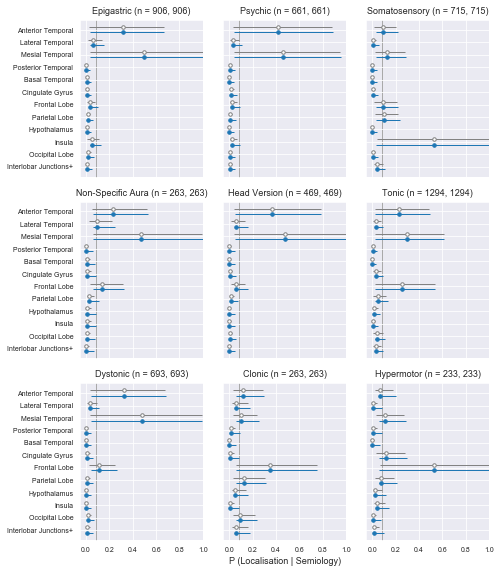

In [996]:
# query_results_normalise
# or query_results

axis='semiology'
processed_dfs_binom = {}
for query_result_name, query_result in query_results.items():
    counts_df = get_counts_df(query_result, region_names, merge_temporal = False, other_included = True)
    counts_df = merge_all_other_semiologies(counts_df, top_9_semiologies)
    roi = region_names['of_interest_minus_tl']+region_names['low_level_temporal_of_interest']
#     roi = region_names['of_interest'] #merge temporal
    counts_df = merge_all_other_zones(counts_df, roi)
    counts_df = counts_df.drop('All other')
    proportion_df = calculate_proportions(counts_df, axis)
    confint_dfs = calculate_confint(counts_df, axis = axis, method = 'binomial', alpha=0.05)
    processed_dfs_binom[query_result_name] = {
        'counts': counts_df,
        'proportion': proportion_df,
        'confints': confint_dfs
    }
    
processed_dfs_sg = {}
for query_result_name, query_result in query_results.items():
    counts_df = get_counts_df(query_result, region_names, merge_temporal = False, other_included = True)
    counts_df = merge_all_other_semiologies(counts_df, top_9_semiologies)
    roi = region_names['of_interest_minus_tl']+region_names['low_level_temporal_of_interest']
#     roi = region_names['of_interest'] #merge temporal
    counts_df = merge_all_other_zones(counts_df, roi)
    counts_df = counts_df.drop('All other')
    proportion_df = calculate_proportions(counts_df, axis)
    confint_dfs = calculate_confint(counts_df, axis = axis, method = 'sison-glaz', alpha=0.05)
    processed_dfs_sg[query_result_name] = {
        'counts': counts_df,
        'proportion': proportion_df,
        'confints': confint_dfs
    }

    
plot_proportion_ci_forest_plot(proportion_df_1 = processed_dfs_binom['full']['proportion'],
                               confint_df_1 = processed_dfs_binom['full']['confints'],
                               counts_df_1 = processed_dfs_binom['full']['counts'],
                               colors = colors,
                               plotter_settings = plotter_settings,
                               labels = labels,
                               proportion_df_2 = processed_dfs_sg['full']['proportion'],
                               confint_df_2 = processed_dfs_sg['full']['confints'],
                               counts_df_2 = processed_dfs_sg['full']['counts'],
                               y_labels = region_names['roi_clean_labels'],
                               overlapping=False
                              )

# plot_proportion_ci_forest_plot(proportion_df_1 = processed_dfs['full']['proportion'],
#                                confint_df_1 = processed_dfs['full']['confints'],
#                                counts_df_1 = counts_df_full_pre_normal,
#                                colors = colors,
#                                plotter_settings = plotter_settings,
#                                labels = labels,
#                                proportion_df_2 = processed_dfs['ss']['proportion'],
#                                confint_df_2 = processed_dfs['ss']['confints'],
#                                counts_df_2 = counts_df_ss_pre_normal,
#                                y_labels = region_names['roi_clean_labels'],
#                                overlapping=False
#                               )

# plt.savefig('/Users/karan/Downloads/binom.png', dpi=1200, pad_inches=0.5)

In [997]:
# plot_proportion_ci_forest_plot(proportion_df_1 = processed_dfs['full']['proportion'],
#                                confint_df_1 = processed_dfs['full']['confints'],
#                                counts_df_1 = processed_dfs['full']['counts'],
#                                colors = colors,
#                                plotter_settings = plotter_settings,
#                                labels = labels,
#                                proportion_df_2 = processed_dfs['ss']['proportion'],
#                                confint_df_2 = processed_dfs['ss']['confints'],
#                                counts_df_2 = processed_dfs['ss']['counts'],
#                                y_labels = region_names['roi_clean_labels'],
#                                overlapping=False
#                               )

In [761]:
def plot_stacked_hbar(proportions_df, ax, ax_title=None, axis='semiology', y_labels=None, color_palette = sns.color_palette("Paired", 12, as_cmap=True)):
    if y_labels is not None:
        proportions_df.columns = y_labels
        
    if axis=='semiology':
        proportions_df=proportions_df
        xlabel = 'P(Localisation | Semiology)'
    elif axis=='zone':
        proportions_df=proportions_df.T
        xlabel = 'P(Semiology | Localisation)'
    else:
        raise ValueError('axis kwarg must be from {semiology, zone}')
    
    proportions_df[::-1].plot(kind='barh', colormap=color_palette, stacked=True,figsize=(10, 4), ax=ax)
    plt.gca().set_xlim((0,1))

    ax.title.set_text(ax_title)
    ax.set_xlabel(xlabel)

In [987]:
axis='zone'
processed_dfs = {}

for query_result_name, query_result in query_results.items():
    counts_df = get_counts_df(query_result, region_names, merge_temporal = False, other_included = True)
    counts_df = merge_all_other_semiologies(counts_df, top_9_semiologies)
    roi = region_names['of_interest_minus_tl']+region_names['low_level_temporal_of_interest']
#     roi = region_names['of_interest'] #merge temporal
    counts_df = merge_all_other_zones(counts_df, roi)
    proportion_df = calculate_proportions(counts_df, axis)
    confint_dfs = calculate_confint(counts_df, axis = axis, method = 'binomial', alpha=0.05)
    processed_dfs[query_result_name] = {
        'counts': counts_df,
        'proportion': proportion_df,
        'confints': confint_dfs
    }

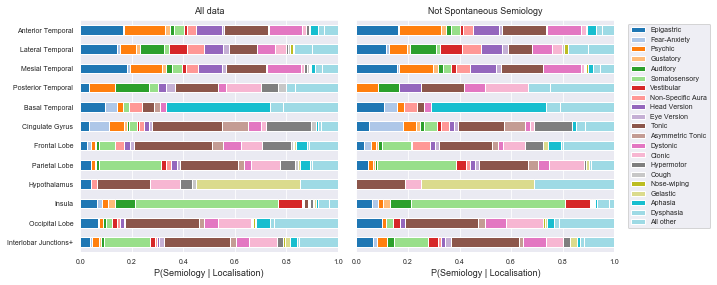

In [986]:
sns.set_style('darkgrid')
# color_palette = sns.color_palette("Paired", 12, as_cmap=True)
color_palette =  sns.color_palette("tab20", as_cmap=True)

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True,)
plot_stacked_hbar(processed_dfs['full']['proportion'], ax=axs[0], ax_title='All data', axis=axis, y_labels=region_names['roi_clean_labels'], color_palette=color_palette)
plot_stacked_hbar(processed_dfs['not_ss']['proportion'], ax=axs[1], ax_title='Not Spontaneous Semiology', axis=axis, y_labels=region_names['roi_clean_labels'], color_palette=color_palette)

axs[0].get_legend().remove()
axs[1].legend(bbox_to_anchor=(1.04,1), loc="upper left")
# labels=region_names['roi_clean_labels']
plt.tight_layout()
plt.savefig('/Users/karan/Downloads/fig2_stacked_by_zone_all_other_20.png', dpi=1200, pad_inches=0.5)

In [ ]:
region_names['roi_clean_labels']

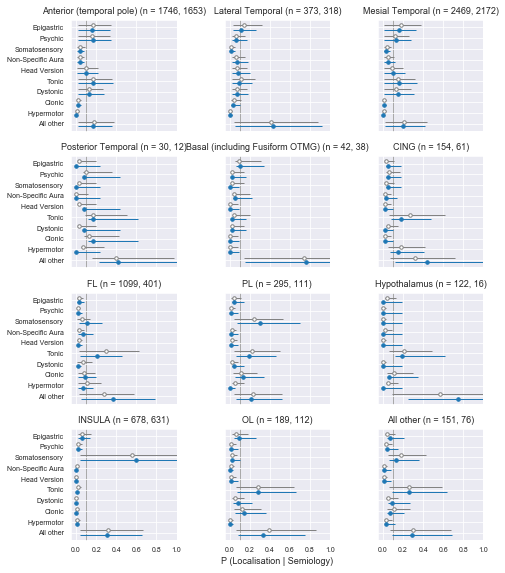

In [988]:
colors = colors

plot_proportion_ci_forest_plot(proportion_df_1 = processed_dfs['full']['proportion'].T,
                               confint_df_1 = processed_dfs['full']['confints'],
                               counts_df_1 = processed_dfs['full']['counts'].T,
                               colors = colors,
                               plotter_settings = plotter_settings,
                               labels = labels,
                               proportion_df_2 = processed_dfs['not_ss']['proportion'].T,
                               confint_df_2 = processed_dfs['not_ss']['confints'],
                               counts_df_2 = processed_dfs['not_ss']['counts'].T,
#                                y_labels = region_names['roi_clean_labels'],
                               overlapping=False
                              )
plt.savefig('/Users/karan/Downloads/weird_by_zone.png', dpi=1200, pad_inches=0.5)

In [307]:
def transpose_if_possible(items):
    transposed_items = []
    try:
        for item in items:
            try:
                transposed_items.append(item.T)
            except AttributeError:
                transposed_items.append(item)
    except TypeError:
        try:
            transposed_items.append(items.T)
        except AttributeError:
            return items
    return transposed_items

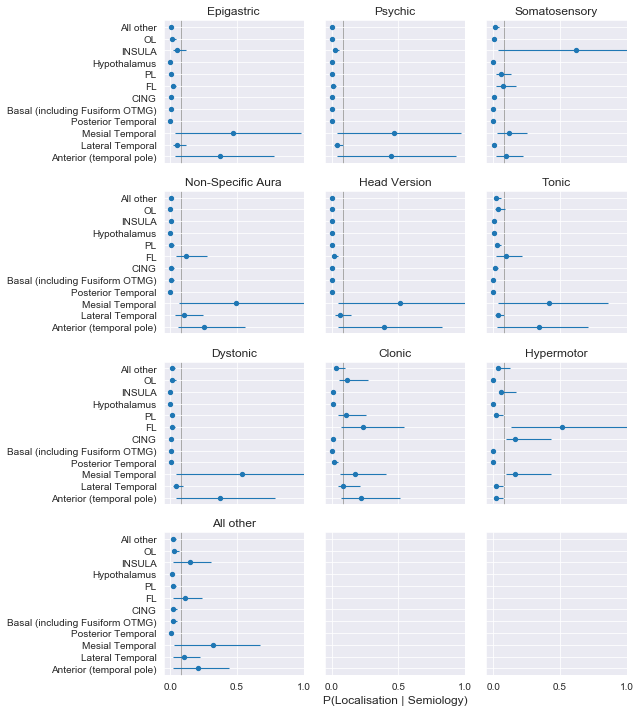

In [212]:
# labels = ['ALl studies', 'Spontaneous Semiology only']
# colors = ['#009988', '#cc3311'] # green, red
# colors = [sns.color_palette("Greys")[3], 'black'] # greys
# colors = [sns.color_palette("Greens")[3], sns.color_palette("Greens")[5]] # greens
# colors = [sns.color_palette("Greys")[4], sns.color_palette("Greens")[5]] # grey-greens
# alphas = [0.9, 1]
# markers = ['o', '^']
vline_color = 'darkgray'

In [ ]:
for j in range(len(x)):
            if j%2 == 0:
                ax.axvspan(0, 1, j/len(x), (j+1)/len(x), facecolor='blue', alpha = 0.3)

In [27]:
def calculate_proportions_by_semiology(counts_df):
    totals_by_zone = counts_df.sum(0)
    proportions_by_zone = counts_df.div(totals_by_zone, axis='columns')
    return proportions_by_zone

In [28]:
def calculate_proportions_by_zone(counts_df):
    totals_by_semiology = counts_df.sum(1)
    proportions_by_semiology = counts_df.div(totals_by_semiology, axis='index')
    return proportions_by_semiology

In [577]:
def calculate_proportions_and_ci(query_results, region_names, merge_temporal = False,  merge_others = True, other_included = True):
    for semiology, value in query_results.items():
#         print(region_names_update)
        query_inspection = value['query_inspection']
        if merge_temporal == False:
            region_names_update =  region_names['low_level_temporal_of_interest'] + region_names['of_interest_minus_tl']
            by_zone_temporal = np.array(query_inspection[region_names['low_level_temporal_of_interest']].sum(0))
            by_zone_minus_temporal = np.array(query_inspection[region_names['of_interest_minus_tl']].sum(0))
            by_zone = np.append(by_zone_temporal, by_zone_minus_temporal)
        else:
            region_names_update = copy.deepcopy(region_names['of_interest'])
            by_zone = np.array(query_inspection[region_names['of_interest']].sum(0))
            
        if other_included and merge_others==True:
            region_names_update += ['All other']
            all_other_zones = query_inspection[region_names['top_level_all_other']].sum(0).sum()
            by_zone = np.append(by_zone, all_other_zones)
            
        elif other_included and merge_others==False:
            region_names_update += region_names['top_level_all_other']
            
        
        if sum(by_zone) != 0:
            proportions = get_proportions(by_zone)
            confint = multinomial_ci_python.sison(by_zone, alpha=0.05)
#             confint = multinomial_proportions_confint(by_zone, alpha=0.05, method='goodman') #sison-glaz throws error?!
            ci = confint[:,1] - confint[:,0]
        else:
            proportions = by_zone
            confint = by_zone
            ci = by_zone
            
        query_results[semiology]['by_zone'] = by_zone
        query_results[semiology]['proportions'] = proportions
        query_results[semiology]['confint'] = confint
        query_results[semiology]['ci'] = ci
        query_results[semiology]['semiology_name'] = semiology
        query_results[semiology]['region_names'] = region_names_update

    return query_results

In [424]:
standard_qr = copy.deepcopy(semiology_query_results)
standard_qr = calculate_proportions_and_ci(standard_qr, region_names, other_included = True, merge_temporal = False)

In [425]:
spontaneous_qr = copy.deepcopy(semiology_query_results_ss)
spontaneous_qr = calculate_proportions_and_ci(spontaneous_qr, region_names, other_included = True, merge_temporal = False)

In [266]:
roi = standard_qr['Epigastric']['region_names']

In [17]:
def get_proportions(values):
    sum_values = np.sum(values)
    proportions = [value/sum_values for value in values]
    return proportions

In [673]:
for semiology, value in spontaneous_qr.items():
    proportions = value['proportions']
for i in proportions:
    print(i, not_good_bootstrap(i))

0.15384615384615385 (0.1485, 0.1619)
0.07692307692307693 (0.0728, 0.0849)
0.07692307692307693 (0.0721, 0.0811)
0.3076923076923077 (0.2993, 0.324)
0.0 (0.0, 0.0)
0.15384615384615385 (0.149, 0.1646)
0.23076923076923078 (0.2251, 0.2429)
0.0 (0.0, 0.0)
0.0 (0.0, 0.0)
0.0 (0.0, 0.0)
0.0 (0.0, 0.0)
0.0 (0.0, 0.0)


In [671]:
def not_good_bootstrap(proportion, n_bootstraps = 100, alpha = 0.05):
    bootstrap_list = []
    for i in range(n_bootstraps):
        boot = (sum(np.random.rand(10000) <= proportion))/10000
        bootstrap_list.append(boot)
    bootstrap_list = np.array(bootstrap_list)
    bootstrap_list.sort()
    lower_ci = bootstrap_list[int(n_bootstraps*alpha)]
    upper_ci = bootstrap_list[int(n_bootstraps*1-alpha)]
    
    return (lower_ci, upper_ci)

In [391]:
def plot_semiology(x, y_labels, ax, vline_color, **kwargs):
    sns.pointplot(x=x,
                  y=y_labels,
                  ax=ax,
                join=False,
                ci=False,
                **kwargs
                )
#     xerr = query_result['confint'].T
#     ax.errorbar(x, y_labels, xerr=xerr, ls='none', color=colors['plot'], alpha=alpha)
        
    ax.title.set_text(query_result['semiology_name'])
    ax.set_xlim([-0.05,1])
    ax.axvline(x=1/len(x),ymin=0,ymax=1,c=vline_color, linewidth=1, zorder=0, clip_on=False)

In [371]:
main_colors = {'plot': '#009988', 'vline': 'darksalmon'} 
ss_colors = {'plot': '#cc3311', 'vline': 'darksalmon'}
#https://personal.sron.nl/~pault/#sec:qualitative

In [369]:
main_colors = {'plot': '#44aa99', 'vline': 'darksalmon'} 
ss_colors = {'plot': '#cc6677', 'vline': 'darksalmon'}
#https://personal.sron.nl/~pault/#sec:qualitative

In [517]:
labels = ['ALl studies', 'Spontaneous Semiology only']
colors = ['#009988', '#cc3311'] # green, red
colors = [sns.color_palette("Greys")[3], 'black'] # greys
colors = [sns.color_palette("Greens")[3], sns.color_palette("Greens")[5]] # greens
colors = [sns.color_palette("Greys")[4], sns.color_palette("Greens")[5]] # grey-greens
alphas = [0.9, 1]
markers = ['o', '^']
vline_color = 'darkgray'

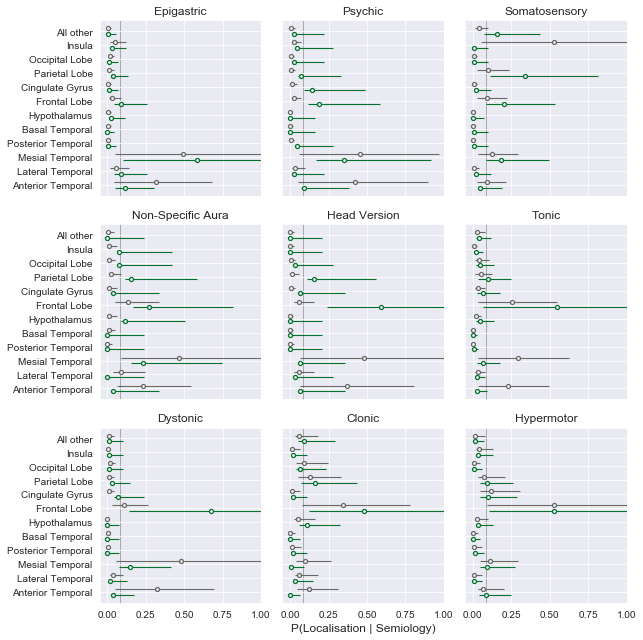

In [518]:
sns.set_style("darkgrid")

fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(9, 9))
for i, semiology in enumerate(top_9_semiologies):
    coord = divmod(i, 3)
    ax = axs[coord[0], coord[1]]
    y_labels = roi_clean_labels
    
    trans1 = Affine2D().translate(0, +0.2) + ax.transData
    trans2 = Affine2D().translate(0, -0.2) + ax.transData
    transforms = [trans1, trans2]
    
    for n_qr, qr in enumerate([standard_qr, spontaneous_qr]):
        query_result = qr[semiology]
        x = query_result['proportions']
        
        xerr = query_result['confint'].T
        ax.errorbar(x,
                    y_labels,
                    xerr=xerr,
                    ls='none',
                    linewidth = 1.1,
                    marker='o',
                    markeredgewidth=1.3,
                    markersize=4,
                    color=colors[n_qr],
                    alpha = alphas[n_qr],
                    markerfacecolor='white',
                    transform=transforms[n_qr])

    ax.title.set_text(query_result['semiology_name'])
    ax.set_xlim([-0.05,1])
    ax.axvline(x=1/len(x),ymin=0,ymax=1,c=vline_color, linewidth=1, zorder=0, clip_on=False)

axs[2, 1].set_xlabel('P(Localisation | Semiology)', ha='center', fontsize=12)
plt.tight_layout()
plt.savefig('/Users/karan/Downloads/figure1_offset_gg.png', dpi=300, pad_inches=0.3)

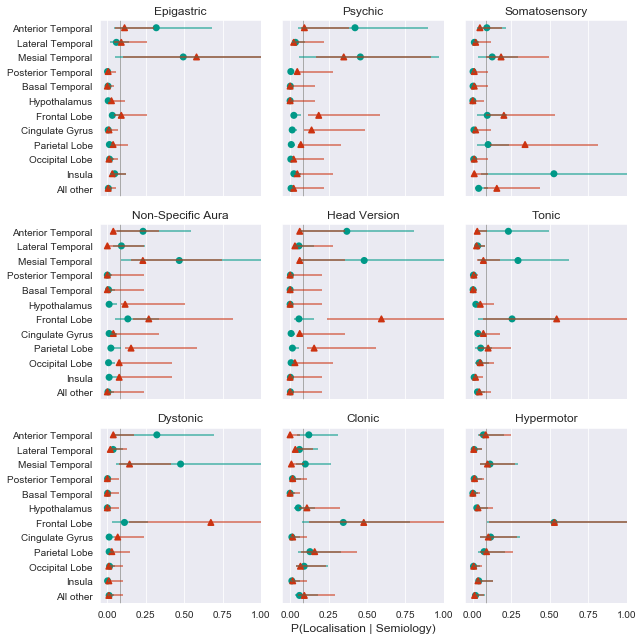

In [438]:
sns.set_style("darkgrid")

fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(9, 9))
for i, semiology in enumerate(top_9_semiologies):
    coord = divmod(i, 3)
    ax = axs[coord[0], coord[1]]
    y_labels = roi_clean_labels
    
    for n_qr, qr in enumerate([standard_qr, spontaneous_qr]):
        query_result = qr[semiology]
        x = query_result['proportions']
        
        xerr = query_result['confint'].T
        ax.errorbar(x, y_labels, xerr=xerr, ls='none', color=colors[n_qr], alpha = 0.7)
        
    for n_qr, qr in enumerate([standard_qr, spontaneous_qr]):
        query_result = qr[semiology]
        x = query_result['proportions']
        plot_semiology(x, y_labels, ax, vline_color, scale=0.8, label=labels[n_qr], color=colors[n_qr], markers=markers[n_qr], transform=transforms[n_qr])

axs[2, 1].set_xlabel('P(Localisation | Semiology)', ha='center', fontsize=12)
plt.tight_layout()
plt.savefig('/Users/karan/Downloads/figure1_overlap_.png', dpi=300, pad_inches=0.3)

In [394]:
# roi = region_names['of_interest_minus_tl'] + region_names['low_level_temporal_of_interest']
# total_by_zone = df[roi].sum(0)
# all_other_total = df[region_names['top_level_all_other']].sum().sum()
# all_other_total = pd.Series([all_other_total], index=['All other'])
# total_by_zone = total_by_zone.append(all_other_total)

In [299]:
count_matrix = []
for semiology in top_9_semiologies:
    count_matrix.append(standard_qr[semiology]['by_zone'])

In [300]:
counts_df = pd.DataFrame(np.array(count_matrix), columns=standard_qr[semiology]['region_names'], index=top_9_semiologies)
# counts_df['sum'] = counts_df.sum(1)
# counts_df.loc['sum'] = counts_df.sum(0)

In [301]:
counts_df

,Anterior (temporal pole),Lateral Temporal,Mesial Temporal,Posterior Temporal,Basal (including Fusiform OTMG),Hypothalamus,FL,CING,PL,OL,INSULA,Any other
Epigastric,288.0,53.0,447.0,1.0,4.0,5.0,29.0,5.0,12.0,13.0,43.0,6.0
Psychic,279.0,23.0,302.0,3.0,1.0,0.0,16.0,9.0,5.0,3.0,16.0,4.0
Somatosensory,65.0,7.0,90.0,1.0,1.0,0.0,67.0,5.0,71.0,4.0,377.0,27.0
Non-Specific Aura,61.0,24.0,123.0,0.0,2.0,3.0,35.0,3.0,6.0,2.0,3.0,1.0
Head Version,173.0,27.0,226.0,1.0,0.0,0.0,27.0,3.0,7.0,3.0,1.0,1.0
Tonic,299.0,41.0,380.0,5.0,2.0,25.0,330.0,42.0,66.0,54.0,11.0,39.0
Dystonic,223.0,26.0,330.0,1.0,1.0,0.0,77.0,8.0,8.0,10.0,1.0,8.0
Clonic,32.0,16.0,26.0,4.0,0.0,14.0,91.0,3.0,34.0,24.0,3.0,16.0
Hypermotor,16.0,2.0,26.0,2.0,0.0,6.0,123.0,27.0,17.0,1.0,9.0,4.0


In [302]:
totals_by_zone = counts_df.sum(0)
totals_by_semiology = counts_df.sum(1)
proportions_by_zone = copy.deepcopy(counts_df)

In [305]:
proportions_by_zone = counts_df.div(totals_by_zone, axis='columns')
proportions_by_semiology = counts_df.div(totals_by_semiology, axis='index')

In [306]:
proportions_by_zone

,Anterior (temporal pole),Lateral Temporal,Mesial Temporal,Posterior Temporal,Basal (including Fusiform OTMG),Hypothalamus,FL,CING,PL,OL,INSULA,Any other
Epigastric,0.200557,0.242009,0.229231,0.055556,0.363636,0.094340,0.036478,0.047619,0.053097,0.114035,0.092672,0.056604
Psychic,0.194290,0.105023,0.154872,0.166667,0.090909,0.000000,0.020126,0.085714,0.022124,0.026316,0.034483,0.037736
Somatosensory,0.045265,0.031963,0.046154,0.055556,0.090909,0.000000,0.084277,0.047619,0.314159,0.035088,0.812500,0.254717
Non-Specific Aura,0.042479,0.109589,0.063077,0.000000,0.181818,0.056604,0.044025,0.028571,0.026549,0.017544,0.006466,0.009434
Head Version,0.120474,0.123288,0.115897,0.055556,0.000000,0.000000,0.033962,0.028571,0.030973,0.026316,0.002155,0.009434
Tonic,0.208217,0.187215,0.194872,0.277778,0.181818,0.471698,0.415094,0.400000,0.292035,0.473684,0.023707,0.367925
Dystonic,0.155292,0.118721,0.169231,0.055556,0.090909,0.000000,0.096855,0.076190,0.035398,0.087719,0.002155,0.075472
Clonic,0.022284,0.073059,0.013333,0.222222,0.000000,0.264151,0.114465,0.028571,0.150442,0.210526,0.006466,0.150943
Hypermotor,0.011142,0.009132,0.013333,0.111111,0.000000,0.113208,0.154717,0.257143,0.075221,0.008772,0.019397,0.037736


In [363]:
color_palette = sns.color_palette("Paired", 12, as_cmap=True)

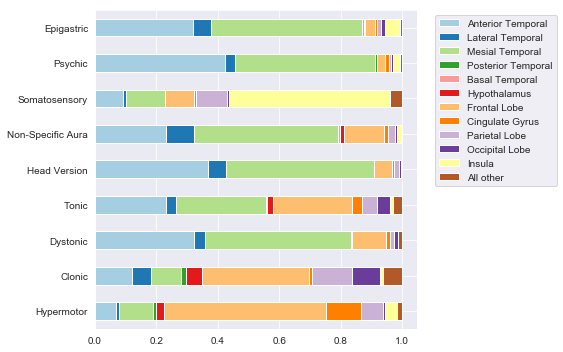

In [531]:
sns.set_style('darkgrid')

# fig, axs = plt.subplots(1, figsize=(8, 5))
proportions_by_semiology.columns = roi_clean_labels
proportions_by_semiology[::-1].plot(kind='barh', colormap=color_palette, stacked=True, figsize=(8, 5))
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.tight_layout()
plt.savefig('/Users/karan/Downloads/fig2_stacked_by_semiology.png', dpi=300, pad_inches=0.3)

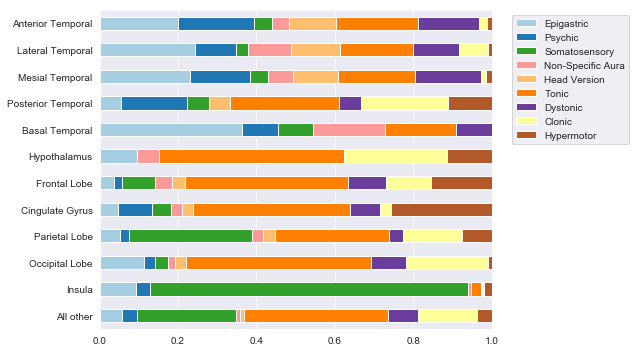

In [539]:
# fig, axs = plt.subplots(1, figsize=(5, 5))
sns.set_style('darkgrid')
proportions_by_zone.columns = roi_clean_labels
proportions_by_zone.T[::-1].plot(kind='barh', colormap=color_palette, stacked=True, figsize=(9, 5))
plt.gca().set_xlim((0,1))
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.tight_layout()
plt.savefig('/Users/karan/Downloads/fig2_stacked_by_zone.png', dpi=300, pad_inches=0.5)

In [364]:
def plot_from_table(colors, ax, axis_title, **kwargs):
    alpha=0.8
    scale=0.9
    sns.pointplot(
                join=False,
                ci=False,
                ax=ax,
                color=colors['plot'],
                alpha=alpha,
                scale=scale,
#                   marker='triangle_up',
                **kwargs
                )
#     xerr = query_result['confint'].T
#     ax.errorbar(x, y, xerr=xerr, ls='none', color=colors['plot'], alpha=alpha)
        
    ax.title.set_text(axis_title)
    ax.set_xlim([-0.05,1])
    ax.axvline(x=1/len(kwargs['x']),ymin=0,ymax=1,c=colors['vline'], linewidth=1, zorder=0, clip_on=False)

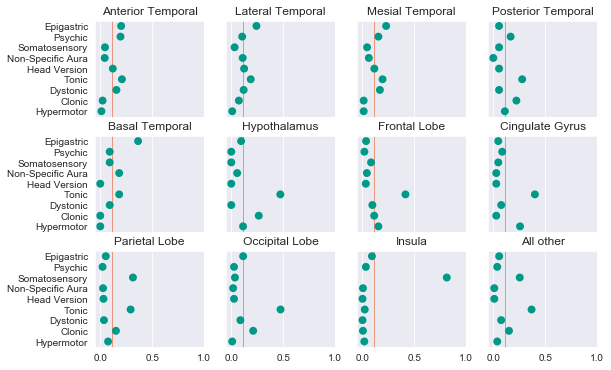

In [366]:
sns.set_style("darkgrid")

fig, axs = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(9, 6))
for i, region in enumerate(roi_clean_labels):
    coord = divmod(i, 4)
    plot_from_table(colors=main_colors,
                    ax = axs[coord[0],coord[1]],
                    axis_title = region,
                    x=proportions_by_zone[region].values,
                    y=proportions_by_zone[region].index,
                    markers='o',
                    )

    
    
#     plot_semiology(proportions_by_zone[semiology], colors=ss_colors, ax = axs[coord[0], coord[1]], label='Spontaneous Semiology', markers='o')
#     plot_semiology(standard_qr[semiology], colors=main_colors, ax = axs[coord[0], coord[1]], label='All studies', markers='^')

# fig.text(0.5, 0.07, 'P(Localisation | Semiology)', ha='center', fontsize=12)
# plt.savefig('/Users/karan/Downloads/figure.png', dpi=300, pad_inches=0.3)

--------------------------------------------
SCRATCH
--------------------------------------------

In [ ]:
[roi[i] for i in my_order]

In [ ]:
regions_of_interest = ['Mesial Temporal',
                         'Lateral Temporal',
                         'Anterior (temporal pole)',
                         'Posterior Temporal',
                         'TL',
                         'FL',
                         'PL',
                         'OL',
                         'INSULA',
                         'CING',
                        ]
# regions_of_interest.sort()
temporal_regions = ['Anterior (temporal pole)',
 'Lateral Temporal',
 'Mesial Temporal',
 'Posterior Temporal']



In [ ]:
all_regions = """TL
Anterior (temporal pole)
Lateral Temporal
STG (includes Transverse Temporal Gyrus, Both Planum)
Transverse Temporal Gyrus (Heschl's, BA 41,  42, ?opercula)
Planum Temporale
Planum Polare
MTG
ITG
Mesial Temporal
Ant Mesial Temporal
Post Mesial Temporal
Enthorinal Cortex
Fusiform
AMYGD
PARAHIPPOCAMPUS
HIPPOCAMPUS
Posterior Temporal
Basal (including Fusiform OTMG)
OTMG (fusiform)
FL
frontal pole
Pre-frontal (BA 8, 9, 10, 11, 12, 13, 14, 24, 25, 32, 44, 45, 46, 47)
DL-PFC (BA 46) (include subgroups BA 9, 8, 10 - frontopolar/anterior prefrontal)
gyrus rectus (basal = gyrus rectus and OFC)
Orbito-frontal (BA 10, 11, 12/47) (basal = gyrus rectus and OFC)
Post OF
Lat OF
Med OF
Medial Frontal (include medial premotor and its constituents as its subsets)
Primary Motor Cortex (Pre-central gyrus, BA 4, Rolandic)
medial precentral
Rolandic Operculum (low BA4)
SFG (F1)
Med SFG
Post SFG
Ant SFG
MFG (F2)
Ant MFG
Mid MFG
Post MFG
Pars Triangularis (subgroup IFG)
Pars opercularis (BA 44)(subgroup IFG, ?opercula)
Premotor frontal (posterior frontal)
Ant Premotor (BA 8, frontal-eye-fields)
Medial Premotor (including pre SMA)
SMA (pre-central gyrus; posterior SFG, MFG)
SSMA
CING
Cingulum (WM)
Ant Cing (frontal, genu)
Dorsal Ant Cing (BA 32)
Middle Cingulate
Post Cing
Isthmus
PL
Primary Sensory Cortex (post-central gyrus)
medial anterior parietal
Sup. pariet. lobule
Precuneus (medial post sup parietal lobule)
Inferior Parietal Lobule
Supramarg gyrus (post part of parietal operculum)
Angular gyrus (BA 39)
parietal operculum (ceiling of secondary somatosensory cortex)
OL
Mesial Occipital
Lingual gyrus  (medial and basal)
Cuneus
Lateral Occipital (SOG, IOG, LOG)
Posterior Occipital Gyrus
Superior Occipital Gyrus
INSULA
Ant Ins
Anterior Short Gyrus
Middle Short Gyrus
Post short gyrus
Precentral gyrus
Postcentral gyrus
Posterior long gyrus
Hypothalamus
Sub-Callosal Cortex
Cerebellum
Hemisphere
Vermis
FT
TO
TP
FTP
TPO Junction
PO
FP
Perisylvian""".splitlines()

all_regions += ['''IFG (F3)
(BA 44,45,47)''',
'''Lateral Premotor
(BA 6)''',
'''Pars orbitalis (subgroup of IFG)
(BA 47)''']
# '''Pars opercularis (BA 44)(subgroup IFG, ?opercula)'''

In [ ]:
other_regions = set(all_regions) - set(regions_of_interest)
other_regions = list(other_regions)

regions_of_interest_minus_temporal = set(regions_of_interest) - set(temporal_regions)
regions_of_interest_minus_temporal = list(regions_of_interest_minus_temporal)